## Genre clustering

Generate visualisations of the relationships between musical genres

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from adjustText import adjust_text
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm

Download and read data

In [142]:
from src.data_loader import download_data

df=download_data()

Loading cached data from data/raw/spotify_data.csv


Import preprocessing functions

In [143]:
from src.preprocessing import SpotifyPreprocessor
preprocessor = SpotifyPreprocessor()

Drop duplicate rows and remove non-numeric features (e.g. track name)

In [144]:
df = preprocessor.clean_data(df)

Encode "explicit", "key" and "time_signature" features using one-hot encoding

In [145]:
df=preprocessor.encode_features(df)

Save dataframe with unscaled numerical values for future use

In [146]:
df_unscaled = df

Scale non-encoded features

In [147]:
# Define numeric columns
numeric_cols = ["popularity","duration_ms","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]
  
# Perform Scaling
df = preprocessor.scale_features(df, numeric_cols)

Apply hierachical clustering to dataset averaged by genre. Genres which share the most features appear closer together. Construct a dendrogram to visualise this clustering and choose an appropriate threshold value at which to group genres.

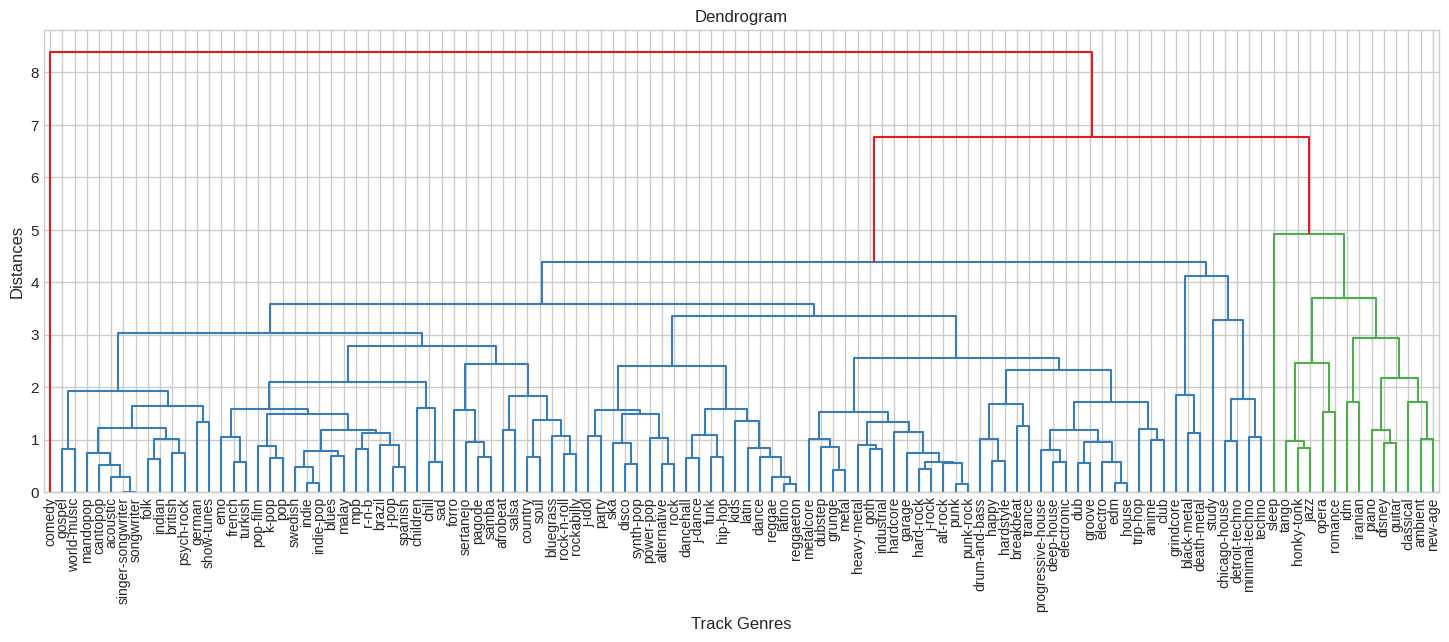

In [148]:
import scipy.cluster.hierarchy as sch

# Group by genre
genres_average = df.groupby('track_genre').mean()
# Perform hierarchical clustering
plt.figure(figsize=(18, 6))
dendrogram = sch.dendrogram(sch.linkage(genres_average, method='complete'), labels=genres_average.index)

# Show the dendrogram
plt.title('Dendrogram')
plt.xlabel('Track Genres')
plt.ylabel('Distances')

# Increase the size of x-labels
plt.tick_params(axis='x', labelsize=10)

# Show the plot
plt.show()

Choose a threshold by eye of 1. Produce the final clusters in the form of a dictionary using fclusters.

In [149]:
from scipy.cluster.hierarchy import fcluster

# Perform hierarchical clustering
linkage_matrix = sch.linkage(genres_average, method='complete')

# Specify the distance threshold
threshold = 1

# Extract the cluster labels based on the threshold
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Add cluster labels to the original DataFrame
genres_average['Cluster'] = clusters

# # Set the maximum number of rows to display
# pd.set_option('display.max_rows', 60)

# Create a dictionary to store classes and clusters
cluster_dict = {}
for i, (cluster, category) in enumerate(zip(clusters, genres_average.index)):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = []
    cluster_dict[cluster].append(category)

ordered_cluster_dict = dict(sorted(cluster_dict.items()))

# Display the dictionary sorted by cluster    
ordered_cluster_dict

{np.int32(1): ['gospel', 'world-music'],
 np.int32(2): ['acoustic',
  'cantopop',
  'mandopop',
  'singer-songwriter',
  'songwriter'],
 np.int32(3): ['folk', 'indian'],
 np.int32(4): ['british', 'psych-rock'],
 np.int32(5): ['german'],
 np.int32(6): ['show-tunes'],
 np.int32(7): ['french', 'turkish'],
 np.int32(8): ['emo'],
 np.int32(9): ['k-pop', 'pop', 'pop-film'],
 np.int32(10): ['blues', 'indie', 'indie-pop', 'malay', 'swedish'],
 np.int32(11): ['mpb', 'r-n-b'],
 np.int32(12): ['brazil', 'j-pop', 'spanish'],
 np.int32(13): ['chill', 'sad'],
 np.int32(14): ['children'],
 np.int32(15): ['pagode', 'samba', 'sertanejo'],
 np.int32(16): ['forro'],
 np.int32(17): ['afrobeat'],
 np.int32(18): ['salsa'],
 np.int32(19): ['country', 'soul'],
 np.int32(20): ['rock-n-roll', 'rockabilly'],
 np.int32(21): ['bluegrass'],
 np.int32(22): ['j-idol'],
 np.int32(23): ['party'],
 np.int32(24): ['disco', 'ska', 'synth-pop'],
 np.int32(25): ['alternative', 'rock'],
 np.int32(26): ['power-pop'],
 np.int3

Manually provide descriptive labels for new clusters

In [150]:
consolidated_genres = {'roots': ['gospel', 'world-music'],
 'vocal-pop': ['acoustic',
  'cantopop',
  'mandopop',
  'singer-songwriter',
  'songwriter'],
 'world-folk': ['folk', 'indian'],
 'wavy-rock': ['british', 'psych-rock'],
 'france-and-diaspora': ['french', 'turkish'],
 'pop': ['k-pop', 'pop', 'pop-film'],
 'indie-and-blues': ['blues', 'indie', 'indie-pop', 'malay', 'swedish'],
 'rnb': ['mpb', 'r-n-b'],
'world-pop': ['brazil', 'j-pop', 'spanish'],
 'laid-back': ['chill', 'sad'],
 'world-rhythm': ['pagode', 'samba', 'sertanejo'],
 'country-soul': ['country', 'soul'],
 'rock-n-roll': ['rock-n-roll', 'rockabilly'],
 'disco-ska': ['disco', 'ska', 'synth-pop'],
 'alt-rock': ['alternative', 'rock'],
 'j-dancehall': ['dancehall', 'j-dance'],
 'funk-hip-hop': ['funk', 'hip-hop'],
 'latin-dance': ['dance', 'latin', 'latino', 'reggae', 'reggaeton'],
 'heavy-grunge': ['dubstep', 'grunge', 'metal'],
 'heavy-rock': ['goth', 'heavy-metal', 'industrial'],
 'punk-rock': ['alt-rock',
  'garage',
  'hard-rock',
  'j-rock',
  'punk',
  'punk-rock'],
 'hardcore-happy': ['happy', 'hardstyle'],
 'deep-electronic': ['deep-house', 'electronic', 'progressive-house'],
 'groovy-electronic': ['dub', 'edm', 'electro', 'groove', 'house'],
 'anime-club': ['anime', 'club'],
 'us-techno-house': ['chicago-house', 'detroit-techno'],
 'jazz-tango': ['honky-tonk', 'jazz', 'tango'],
 'disney-guitar': ['disney', 'guitar']}

Remap clustered genre names in dataframe

In [151]:
# Create a dictionary to map old genres to new genres
genre_map = {old_genre: new_genre for new_genre, old_genres in consolidated_genres.items() for old_genre in old_genres}

# Replace the old genres with the new genres
df['track_genre'] = df['track_genre'].replace(genre_map)
df_unscaled['track_genre'] = df_unscaled['track_genre'].replace(genre_map)

Label-encode genres

In [152]:
from sklearn.preprocessing import LabelEncoder

# Define the target and explanatory features
X = df.drop("track_genre", axis=1).values
y = df["track_genre"].values

# Perform Label Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Store the genres encoded in the label encoder
genres = label_encoder.classes_

In [153]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Choose features to be displayed on radar plot
audio_features = ['danceability', 'energy', 'valence', 'acousticness', 
                 'instrumentalness', 'speechiness', 'liveness']

# Calculate mean values for each genre
genre_profiles = df_unscaled.groupby('track_genre')[audio_features].mean()

genre_profiles_scaled = genre_profiles * 100


In [154]:
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go

def create_ipywidgets_multi_genre_radar(genre_data):
    
    # Create multi-select widget
    genre_options = [(genre.title(), genre) for genre in genre_data.index]
    
    multi_select = widgets.SelectMultiple(
        options=genre_options,
        value=list(genre_data.index)[:3],  # Default selection
        description='Genres:',
        disabled=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px', height='150px')
    )
    
    # Create output widget for the plotq
    output = widgets.Output()
    
    def update_plot(change=None):

        # Update radar chart based on widget selection
        
        with output:
            output.clear_output(wait=True)
            
            selected_genres = multi_select.value
            if not selected_genres:
                print("Please select at least one genre")
                return
            
            fig = go.Figure()
            colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
            features = list(genre_data.columns)
            
            for i, genre in enumerate(selected_genres):
                values = list(genre_data.loc[genre])
                values_closed = values + [values[0]]
                features_closed = features + [features[0]]
                
                fig.add_trace(go.Scatterpolar(
                    r=values_closed,
                    theta=features_closed,
                    fill='toself',
                    name=genre.title(),
                    line_color=colors[i % len(colors)]
                ))
            
            fig.update_layout(
                polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
                title=f"Genre Comparison: {', '.join([g.title() for g in selected_genres])}",
                showlegend=True,
                height=600
            )
            
            fig.show()
    
    # Connect widget to update function
    multi_select.observe(update_plot, names='value')
    
    # Display widgets
    display(widgets.VBox([multi_select, output]))
    
    # Initial plot
    update_plot()

# Usage in Jupyter notebook
create_ipywidgets_multi_genre_radar(genre_profiles)


Plots to show which genres are most closely related to one another

In [ ]:
def create_mds_plot(genre_data, n_clusters=5):

    # Set seaborn style
    sns.set_theme(style="whitegrid", palette="Set1")
    
    # Perform clustering and MDS
    distance_matrix = pdist(genre_data, metric='cosine')
    distance_matrix_square = squareform(distance_matrix)
    
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_results = mds.fit_transform(distance_matrix_square)

    # Manually name clusters
    cluster_names = {
            1: "Easy Listening",
            2: "Classical Romantic", 
            3: "Popular",
            4: "Comedy",
            5: "Energetic Beats",
            6: "Heavy Beats"
        }
    
    # Create DataFrame
    plot_df = pd.DataFrame({
        'MDS_1': mds_results[:, 0],
        'MDS_2': mds_results[:, 1],
        'Genre': [genre.title() for genre in genre_data.index],
        'Cluster_Name': [cluster_names.get(label, f'Cluster {label}') for label in cluster_labels]
    })
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    plt.grid(visible=False)
    
    ax = sns.scatterplot(
        data=plot_df,
        x='MDS_1', 
        y='MDS_2',
        hue='Cluster_Name',  
        s=200,
        alpha=0.8,
        edgecolor='white',
        linewidth=2
    )
    
    # Create text annotations 
    texts = []
    for i, row in plot_df.iterrows():
        text = ax.text(
            row['MDS_1'], 
            row['MDS_2'], 
            row['Genre'],
            fontsize=8,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='round,pad=0.3', 
                facecolor='white', 
                alpha=0.8,
                edgecolor='gray',
                linewidth=0.5
            )
        )
        texts.append(text)
    
    # Automatically adjust text positions to avoid overlap
    adjust_text(
        texts, 
        arrowprops=dict(
            arrowstyle='-', 
            color='gray', 
            alpha=0.6,
            lw=1
        ),
        expand_points=(1.2, 1.2),  # Expand around points
        expand_text=(1.1, 1.1),   # Expand around text
        force_points=0.5,         # Force away from points
        force_text=1.2,           # Force away from other text
        ax=ax
    )
    
    # Enhance plot styling
    ax.set_title(
        'Music Genre Landscape', 
        fontsize=16, 
        fontweight='bold',
        pad=20
    )
    ax.set_xlabel('MDS Component 1', fontsize=12, fontweight='semibold')
    ax.set_ylabel('MDS Component 2', fontsize=12, fontweight='semibold')
    
    # Legend
    legend = ax.legend(
        title='Genre Clusters',
        bbox_to_anchor=(1.05, 0.65), 
        fontsize=12, 
        loc='upper left',
        frameon=True,
        fancybox=True,
    )
    legend.get_title().set_fontweight('bold')
    
    # # Add stress information
    # stress_text = f'MDS Stress: {mds.stress_:.3f}'
    # ax.text(
    #     0.02, 0.98, stress_text,
    #     transform=ax.transAxes,
    #     fontsize=10,
    #     verticalalignment='top',
    #     bbox=dict(
    #         boxstyle="round,pad=0.5", 
    #         facecolor="lightblue", 
    #         alpha=0.8,
    #         edgecolor='navy'
    #     )
    # )
    
    plt.tight_layout()
    plt.show()
    
    return plot_df, mds.stress_

# Usage
clean_df, stress = create_mds_plot(genre_profiles_scaled, n_clusters=6)


TypeError: plot_mds_clusters() got an unexpected keyword argument 'n_clusters'

In [ ]:
genre_dict = clean_df.set_index('Genre')['Cluster_Name'].to_dict()
genre_dict =  {k.lower(): v for k, v in genre_dict.items()}
display(genre_dict)

{'afrobeat': 'Energetic Beats',
 'alt-rock': 'Energetic Beats',
 'ambient': 'Easy Listening',
 'anime-club': 'Energetic Beats',
 'black-metal': 'Heavy Beats',
 'bluegrass': 'Popular',
 'breakbeat': 'Energetic Beats',
 'children': 'Popular',
 'classical': 'Easy Listening',
 'comedy': 'Comedy',
 'country-soul': 'Popular',
 'death-metal': 'Heavy Beats',
 'deep-electronic': 'Energetic Beats',
 'disco-ska': 'Energetic Beats',
 'disney-guitar': 'Easy Listening',
 'drum-and-bass': 'Heavy Beats',
 'emo': 'Energetic Beats',
 'forro': 'Popular',
 'france-and-diaspora': 'Popular',
 'funk-hip-hop': 'Energetic Beats',
 'german': 'Energetic Beats',
 'grindcore': 'Heavy Beats',
 'groovy-electronic': 'Energetic Beats',
 'hardcore': 'Energetic Beats',
 'hardcore-happy': 'Energetic Beats',
 'heavy-grunge': 'Energetic Beats',
 'heavy-rock': 'Energetic Beats',
 'idm': 'Easy Listening',
 'indie-and-blues': 'Popular',
 'iranian': 'Easy Listening',
 'j-dancehall': 'Energetic Beats',
 'j-idol': 'Energetic Bea

In [ ]:
df_unscaled['genre_category'] = df_unscaled['track_genre'].map(genre_dict)

In [ ]:
# Choose features to be displayed on radar plot
audio_features = ['danceability', 'energy', 'valence', 'acousticness', 
                 'instrumentalness', 'speechiness', 'liveness']

# Calculate mean values for each genre
genre_profiles = df_unscaled.groupby('genre_category')[audio_features].mean()

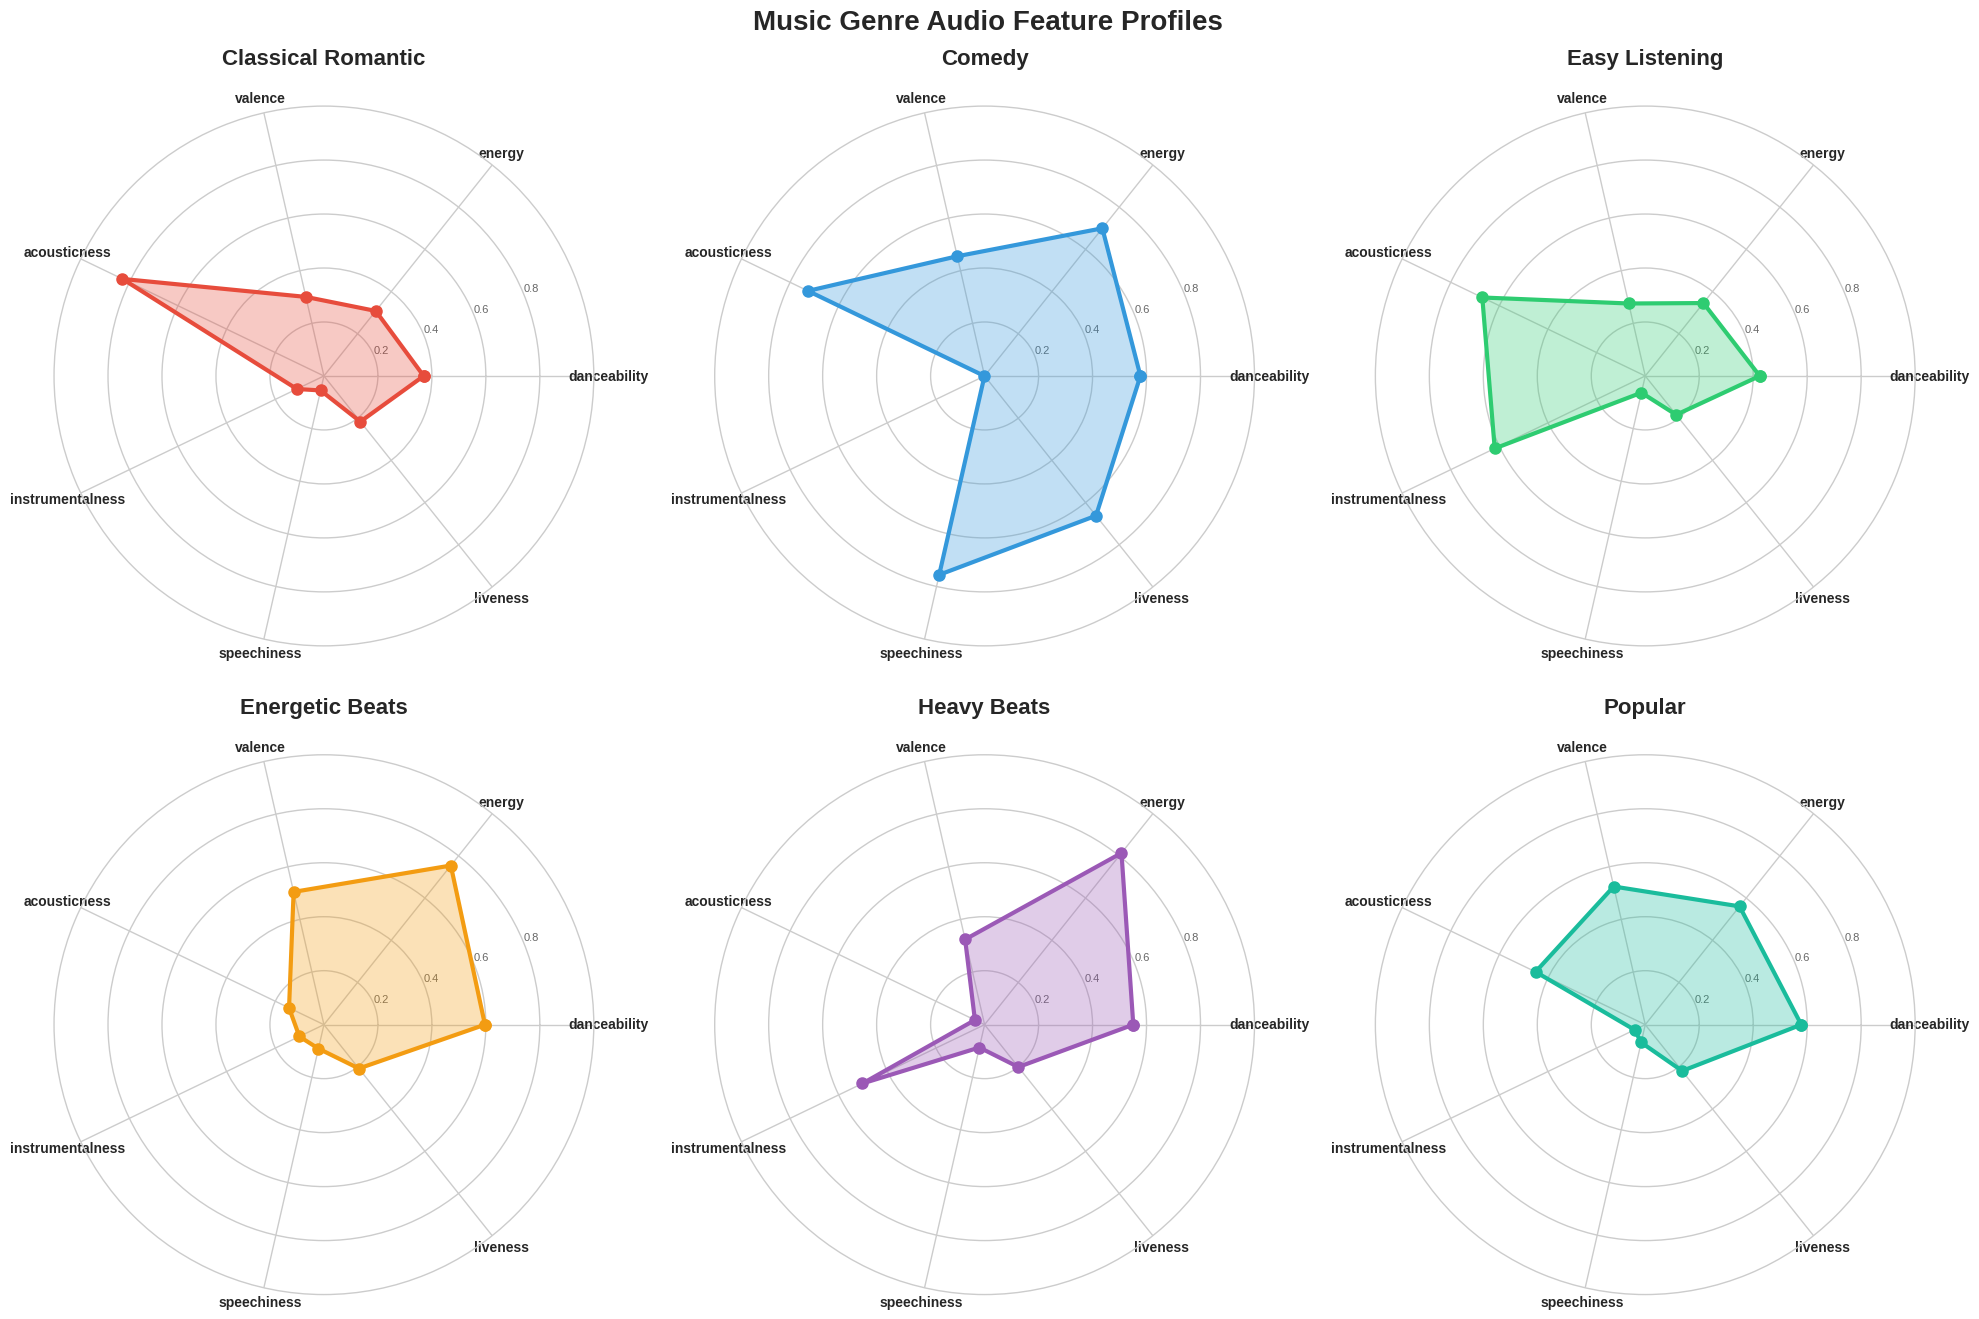

In [ ]:
from src.visualisation import create_radar_subplots

create_radar_subplots(genre_profiles)
